<a href="https://colab.research.google.com/github/Juanje932/Diplomado-IA/blob/master/Proyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de strawberries

link del dataset: https://universe.roboflow.com/saruta-nonthasiriwat-sr2y9/strawberry-tyqqb/dataset/2

Link interesante, datos de paga:  https://www.kaggle.com/datasets/trainingdatapro/ripe-strawberries-detection/data

Mas imagenes, no revisadas: https://universe.roboflow.com/cs2/farm-detect9/dataset/3

In [4]:
# Uso de la API de roboflow
%pip install roboflow

## Descargar el dataset


In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="fDfY37GxkyGoaJ1AfIFM")
project= rf.workspace("saruta-nonthasiriwat-sr2y9").project("strawberry-tyqqb")
version = project.version(2)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


## Visualización de los datos

In [6]:
# Codigo utilizable como libreria
import os
import yaml
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import shutil

def load_yaml_config(yaml_path):
    """
    Carga un archivo de configuración YAML.

    Args:
        yaml_path (str): Ruta al archivo YAML.

    Returns:
        dict: Contenido del YAML parseado.
    """
    with open(yaml_path, 'r') as file:
        return yaml.safe_load(file)

def count_classes(labels_dir):
    """
    Cuenta las ocurrencias de cada clase en los archivos de etiquetas de un directorio dado.

    Args:
        labels_dir (str): Ruta al directorio que contiene los archivos de etiquetas.

    Returns:
        Counter: Un objeto Counter con los conteos de clases.
    """
    class_counter = Counter()
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1
    return class_counter

def analyze_class_balance(config_path):
    """
    Analiza el balance de clases en el conjunto de datos según lo especificado en el archivo de configuración.

    Args:
        config_path (str): Ruta al archivo de configuración YAML.

    Returns:
        pd.DataFrame: DataFrame que contiene los conteos de clases para cada división del conjunto de datos.
    """
    config = load_yaml_config(config_path)
    classes = config['names']
    datasets = ['train', 'valid', 'test']
    base_dir = os.path.dirname(config_path)

    results = {}
    for dataset in datasets:
        labels_dir = os.path.join(base_dir, dataset, 'labels')
        if os.path.exists(labels_dir):
            results[dataset] = count_classes(labels_dir)
        else:
            print(f"Advertencia: El directorio '{labels_dir}' no existe. Saltando el conjunto de datos {dataset}.")
            results[dataset] = Counter()

    # Creación del DataFrame
    df = pd.DataFrame({dataset: [results[dataset].get(i, 0) for i in range(len(classes))] for dataset in datasets}, index=classes)

    return df


def plot_class_balance(df):
    """
    Genera un gráfico de barras para visualizar el balance de clases en los diferentes conjuntos de datos.

    Args:
        df (pd.DataFrame): DataFrame que contiene los conteos de clases para cada división del conjunto de datos.
    """
    ax = df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Balance de Clases en los Conjuntos de Datos')
    plt.xlabel('Clases')
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.legend(title='Conjuntos de Datos')
    plt.tight_layout()
    plt.show()


def remove_directory_if_exists(directory_path):
    """
    Elimina un directorio si existe.

    Args:
        directory_path (str): La ruta del directorio a eliminar.
    """
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directorio '{directory_path}' eliminado exitosamente.")
    else:
        print(f"Directorio '{directory_path}' no existe.")

**NOTA: Es necesario que el dataset se encuentre en el siguiente formato.**


```plaintext
strawberry-2
├── test
├── train
├── valid
└── data.yaml
```



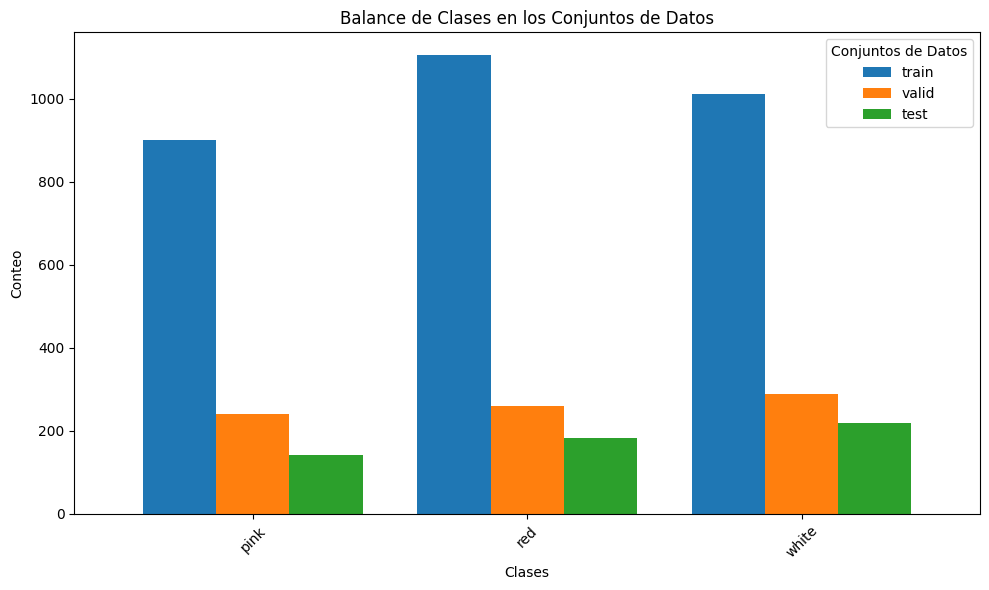

       train  valid  test
pink     901    241   142
red     1105    260   182
white   1011    290   218


In [8]:
class_balance_df = analyze_class_balance(r'/content/strawberry-2/data.yaml')
plot_class_balance(class_balance_df)
print(class_balance_df)

# Instalación de Ultralytics

In [9]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [10]:
import yaml

# Definir el contenido del archivo YAML
data = {
    'names': ['pink', 'red', 'white'],
    'nc': 3,
    'test': '/content/strawberry-2/test',
    'train': '/content/strawberry-2/train',
    'val': '/content/strawberry-2/valid'
}

path = r'/content/strawberry-2/data.yaml'

# Escribir el contenido en un archivo YAML
with open(path , 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("Archivo data.yaml creado exitosamente.")


Archivo data.yaml creado exitosamente.


Descripción de la Arquitectura: https://docs.ultralytics.com/yolov5/tutorials/architecture_description/

In [ ]:
remove_directory_if_exists(r'D:\Diplomado-IA\Modulo_5_extendido\Proyecto_1\runs')

In [11]:
from ultralytics import YOLO

model = YOLO("yolov5nu.pt")  # Entrenamiento con pesos pre-entrenados

#model = YOLO("yolov5s.yaml") # Entrenamiento desde cero, revisar los modelos en https://docs.ultralytics.com/models/yolov5/#supported-tasks-and-modes
# NOTA: Yolov5su  has moved towards an anchor-free, objectness-free approach. Sin embargo los detalles arquitectonicos son no cambian, solo el cabezal de detección

model.train(
    data=r"/content/strawberry-2/data.yaml",
    task="detect",
    mode='train',
    epochs=50,          # Número de épocas de entrenamiento
    patience=100,       # Paciencia para el early stopping
    batch=16,           # Tamaño del batch
    imgsz=640,          # Tamaño de la imagen
    save=True,          # Guardar el modelo después de entrenar
    cache=False,        # Usar caché de datos
    device=None,        # Dispositivo para el entrenamiento (None para auto-detectar)
    workers=8,          # Número de workers para el data loading
    pretrained=True,    # Usar pesos pre-entrenados
    optimizer='auto',   # Optimizador
    verbose=True,       # Imprimir información durante el entrenamiento
    seed=0,             # Semilla para la reproducibilidad
    deterministic=True, # Asegurar entrenamiento determinista
    amp=True,           # Mixed precision training
    val=True,           # Validar después de cada época
    split='val',        # División para validación
    iou=0.7,            # Umbral de IoU
    max_det=300,        # Máximo número de detecciones por imagen
    lr0=0.01,           # Tasa de aprendizaje inicial
    lrf=0.01,           # Factor de reducción de la tasa de aprendizaje
    momentum=0.937,     # Momento para SGD
    weight_decay=0.0005,# Decaimiento de peso
    warmup_epochs=3.0,  # Número de épocas de calentamiento
    warmup_momentum=0.8,# Momento durante el calentamiento
    warmup_bias_lr=0.1, # Tasa de aprendizaje para el sesgo durante el calentamiento
    box=7.5,            # Pérdida de la caja
    cls=0.5,            # Pérdida de la clase
    dfl=1.5,            # Pérdida de distribución focal
    mosaic=1.0,         # Probabilidad de aplicar la técnica de mosaic
    auto_augment='randaugment', # Tipo de aumento automático
    erasing=0.4,        # Probabilidad de borrado aleatorio
    save_dir='runs/detect/train', # Directorio para guardar los resultados
    name = 'exp-YOLOV5N'
)


100%|██████████| 5.31M/5.31M [00:00<00:00, 300MB/s]


Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=/content/strawberry-2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=exp-YOLOV5N, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|██████████| 755k/755k [00:00<00:00, 67.7MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 195MB/s]


AMP: checks passed ✅


train: Scanning /content/strawberry-2/train/labels... 699 images, 1 backgrounds, 0 corrupt: 100%|██████████| 699/699 [00:00<00:00, 1309.63it/s]

train: New cache created: /content/strawberry-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/strawberry-2/valid/labels... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<00:00, 1199.40it/s]

val: New cache created: /content/strawberry-2/valid/labels.cache


Plotting labels to runs/detect/exp-YOLOV5N/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/exp-YOLOV5N
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.07G      1.609      2.716       1.35         80        640: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


                   all        193        791      0.477      0.537      0.444      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.98G       1.59      1.879       1.32         79        640: 100%|██████████| 44/44 [00:04<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


                   all        193        791      0.485      0.498      0.459      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.01G      1.582      1.724      1.334         65        640: 100%|██████████| 44/44 [00:04<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


                   all        193        791      0.602      0.581      0.594      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.98G      1.567      1.642      1.326         49        640: 100%|██████████| 44/44 [00:04<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


                   all        193        791      0.654      0.649      0.674      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.04G      1.554      1.584      1.315        105        640: 100%|██████████| 44/44 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


                   all        193        791      0.649      0.617      0.651      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.05G      1.504      1.481      1.299         89        640: 100%|██████████| 44/44 [00:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.22it/s]


                   all        193        791      0.721      0.683      0.732      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.07G      1.531      1.463      1.308         80        640: 100%|██████████| 44/44 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


                   all        193        791       0.56      0.655      0.621      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.98G       1.51      1.431      1.314         95        640: 100%|██████████| 44/44 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


                   all        193        791      0.622      0.659      0.665      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.08G      1.512      1.418      1.289         56        640: 100%|██████████| 44/44 [00:04<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]

                   all        193        791      0.709      0.667      0.703      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.98G      1.485      1.339       1.29         75        640: 100%|██████████| 44/44 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.34it/s]

                   all        193        791      0.669      0.713      0.725      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.06G      1.481      1.323      1.294         55        640: 100%|██████████| 44/44 [00:04<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

                   all        193        791       0.68      0.712      0.727      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.05G      1.476      1.305       1.29         62        640: 100%|██████████| 44/44 [00:04<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


                   all        193        791      0.646      0.723      0.715      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.98G      1.472      1.285      1.276         81        640: 100%|██████████| 44/44 [00:04<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]

                   all        193        791      0.681      0.721      0.736      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.98G      1.463      1.258      1.285         48        640: 100%|██████████| 44/44 [00:04<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


                   all        193        791      0.635      0.722      0.725      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.98G      1.474      1.263      1.291         85        640: 100%|██████████| 44/44 [00:04<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.29it/s]

                   all        193        791      0.675      0.648      0.697        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.06G      1.425      1.188      1.255         89        640: 100%|██████████| 44/44 [00:04<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        193        791      0.672      0.711      0.739      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.03G      1.455      1.218      1.275         61        640: 100%|██████████| 44/44 [00:04<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]

                   all        193        791      0.712      0.736      0.759      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.06G      1.409       1.16      1.247         69        640: 100%|██████████| 44/44 [00:04<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.66it/s]

                   all        193        791      0.697      0.723      0.747      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.05G      1.434      1.167      1.266         74        640: 100%|██████████| 44/44 [00:04<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]

                   all        193        791      0.677      0.697      0.707      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.07G      1.453      1.183      1.275         54        640: 100%|██████████| 44/44 [00:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        193        791      0.664      0.718      0.742      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.05G      1.429      1.146       1.27         68        640: 100%|██████████| 44/44 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.73it/s]

                   all        193        791      0.686      0.706      0.728      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.06G      1.415      1.114      1.265         69        640: 100%|██████████| 44/44 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]

                   all        193        791      0.711      0.686      0.744      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.98G      1.437      1.125      1.261         77        640: 100%|██████████| 44/44 [00:04<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.38it/s]

                   all        193        791      0.717       0.65      0.717      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.03G      1.399      1.104      1.245         36        640: 100%|██████████| 44/44 [00:04<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.69it/s]

                   all        193        791      0.684      0.733      0.761      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.98G      1.392      1.094      1.241         54        640: 100%|██████████| 44/44 [00:04<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]

                   all        193        791      0.679      0.707      0.718      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.98G       1.39      1.063      1.243         63        640: 100%|██████████| 44/44 [00:04<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.26it/s]

                   all        193        791      0.704      0.693      0.729      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.98G      1.406      1.069      1.257         77        640: 100%|██████████| 44/44 [00:04<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]

                   all        193        791      0.685      0.738      0.742      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.98G      1.367      1.065      1.241        107        640: 100%|██████████| 44/44 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.90it/s]

                   all        193        791      0.703      0.712      0.734       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.98G      1.374      1.053      1.243         46        640: 100%|██████████| 44/44 [00:04<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]

                   all        193        791      0.654      0.694      0.701      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.98G      1.358      1.046      1.248         81        640: 100%|██████████| 44/44 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        193        791      0.668      0.733      0.745      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.03G       1.35      1.016       1.23         66        640: 100%|██████████| 44/44 [00:04<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]

                   all        193        791      0.692      0.728      0.743       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.05G      1.357     0.9913      1.231         78        640: 100%|██████████| 44/44 [00:04<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]

                   all        193        791      0.699      0.717      0.738       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.06G      1.356     0.9983      1.231         71        640: 100%|██████████| 44/44 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]

                   all        193        791      0.693      0.711       0.74      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.98G      1.346     0.9716      1.222         93        640: 100%|██████████| 44/44 [00:04<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

                   all        193        791      0.703       0.72      0.758      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.98G      1.364     0.9692      1.237        119        640: 100%|██████████| 44/44 [00:04<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]

                   all        193        791      0.696      0.748      0.771      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.98G      1.315      0.958      1.208         96        640: 100%|██████████| 44/44 [00:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]

                   all        193        791      0.719      0.702      0.755      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.05G      1.304      0.932      1.195         56        640: 100%|██████████| 44/44 [00:04<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]

                   all        193        791      0.681      0.723      0.739      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.05G      1.314     0.9412      1.211         80        640: 100%|██████████| 44/44 [00:04<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]

                   all        193        791      0.695      0.752       0.77      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.98G      1.343     0.9543      1.231         58        640: 100%|██████████| 44/44 [00:04<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]

                   all        193        791      0.704      0.724      0.756      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.05G      1.311     0.9463      1.215         68        640: 100%|██████████| 44/44 [00:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]

                   all        193        791       0.71      0.716      0.757      0.445


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.25G       1.28     0.8766      1.209         60        640: 100%|██████████| 44/44 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        193        791      0.698       0.72      0.752      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.98G      1.271     0.8533      1.198         40        640: 100%|██████████| 44/44 [00:04<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]

                   all        193        791      0.703       0.71      0.753      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.98G      1.254      0.838      1.189         37        640: 100%|██████████| 44/44 [00:04<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]

                   all        193        791      0.722      0.723      0.765      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.98G      1.252     0.8212      1.189         54        640: 100%|██████████| 44/44 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]

                   all        193        791      0.693       0.74      0.752      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.98G      1.244     0.8153      1.179         52        640: 100%|██████████| 44/44 [00:04<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]

                   all        193        791      0.688      0.731      0.744      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.98G      1.223      0.786      1.176         43        640: 100%|██████████| 44/44 [00:04<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]

                   all        193        791      0.735      0.704      0.759      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.98G      1.239     0.8012      1.178         52        640: 100%|██████████| 44/44 [00:04<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]

                   all        193        791      0.712      0.712       0.75       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.98G       1.22     0.7899      1.182         40        640: 100%|██████████| 44/44 [00:04<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.81it/s]

                   all        193        791      0.697      0.725      0.756      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.98G      1.214     0.7671      1.167         29        640: 100%|██████████| 44/44 [00:04<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]

                   all        193        791      0.677      0.743      0.747      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.98G      1.194      0.766      1.155         46        640: 100%|██████████| 44/44 [00:04<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

                   all        193        791      0.672      0.749      0.754       0.43



50 epochs completed in 0.083 hours.
Optimizer stripped from runs/detect/exp-YOLOV5N/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/exp-YOLOV5N/weights/best.pt, 5.3MB

Validating runs/detect/exp-YOLOV5N/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv5n summary (fused): 193 layers, 2,503,529 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


                   all        193        791      0.721      0.722      0.765      0.445
                  pink        126        241      0.706      0.651      0.719      0.431
                   red        133        260      0.778      0.781      0.829      0.492
                 white        136        290      0.678      0.734      0.745      0.411
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to runs/detect/exp-YOLOV5N


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d752ce0c340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Evaluación del modelo entrenado

https://docs.ultralytics.com/modes/val/

In [12]:
metrics = model.val(imgsz = 640, split = 'test', plots = True, name = 'Metrics-test-exp-YOLOV5N')

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv5n summary (fused): 193 layers, 2,503,529 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning /content/strawberry-2/test/labels... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<00:00, 1335.08it/s]

val: New cache created: /content/strawberry-2/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


                   all        119        542      0.667      0.709      0.735      0.422
                  pink         71        142       0.66      0.698       0.69      0.409
                   red         79        182      0.712      0.736      0.803      0.489
                 white         90        218      0.628      0.693      0.711      0.368
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/Metrics-test-exp-YOLOV5N


In [13]:
metrics = model.val(imgsz = 640, split = 'val', plots = True, name = 'Metrics-val-exp-YOLOV5N')

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


val: Scanning /content/strawberry-2/valid/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


                   all        193        791      0.723      0.723      0.764      0.444
                  pink        126        241      0.707      0.651      0.718      0.431
                   red        133        260      0.781      0.782      0.829       0.49
                 white        136        290      0.681      0.734      0.745      0.411
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/Metrics-val-exp-YOLOV5N


In [14]:
metrics = model.val(imgsz = 640, split = 'train', plots = True, name = 'Metrics-train-exp-YOLOV5N')

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


val: Scanning /content/strawberry-2/train/labels.cache... 699 images, 1 backgrounds, 0 corrupt: 100%|██████████| 699/699 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:08<00:00,  5.03it/s]


                   all        699       3017      0.852       0.87      0.925      0.606
                  pink        457        901       0.84      0.847      0.917      0.614
                   red        478       1105      0.908      0.899      0.957      0.651
                 white        469       1011      0.808      0.865      0.902      0.554
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/Metrics-train-exp-YOLOV5N


# Predicciones

In [18]:
from ultralytics import YOLO
model = YOLO(r"/content/runs/detect/exp-YOLOV5N/weights/best.pt")

In [17]:
model.predict(r"/content/strawberry-2/test/images/00314_png_jpg.rf.ec7111bee9ec74ac109f072dc1b9f7fa.jpg", save=True, imgsz=640, conf=0.36)


image 1/1 /content/strawberry-2/test/images/00314_png_jpg.rf.ec7111bee9ec74ac109f072dc1b9f7fa.jpg: 640x640 2 reds, 1 white, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'pink', 1: 'red', 2: 'white'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
   

In [20]:
model.predict(r"/content/strawberry-2/test/images", save=True, imgsz=640, conf=0.35, save_txt = True, save_conf = False)


image 1/119 /content/strawberry-2/test/images/00069_png_jpg.rf.b62e1a59137c46d221c6d57dab03d65c.jpg: 640x640 3 pinks, 1 red, 5 whites, 8.0ms
image 2/119 /content/strawberry-2/test/images/00079_png_jpg.rf.6b856b016e3b45aae79599d59b499651.jpg: 640x640 2 pinks, 1 white, 8.5ms
image 3/119 /content/strawberry-2/test/images/00085_png_jpg.rf.6d76590291c2d4429a5346da2be5476f.jpg: 640x640 2 pinks, 1 red, 10.3ms
image 4/119 /content/strawberry-2/test/images/00107_png_jpg.rf.fb9db7f26d9c33b880de9b8d1aee4a50.jpg: 640x640 2 pinks, 2 whites, 9.4ms
image 5/119 /content/strawberry-2/test/images/00115_png_jpg.rf.ba5001d1d8e4121172cf11304a3f1da9.jpg: 640x640 1 red, 1 white, 8.6ms
image 6/119 /content/strawberry-2/test/images/00116_png_jpg.rf.52228a72d8d8dee0a43ea3c2bd0a5f27.jpg: 640x640 3 pinks, 3 whites, 8.1ms
image 7/119 /content/strawberry-2/test/images/00142_png_jpg.rf.709e33186ce25f54c2bd7f9c286982f3.jpg: 640x640 1 red, 1 white, 8.2ms
image 8/119 /content/strawberry-2/test/images/00161_png_jpg.rf.

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'pink', 1: 'red', 2: 'white'}
 obb: None
 orig_img: array([[[17, 17, 17],
         [17, 17, 17],
         [17, 17, 17],
         ...,
         [17, 17, 17],
         [17, 17, 17],
         [17, 17, 17]],
 
        [[17, 17, 17],
         [17, 17, 17],
         [17, 17, 17],
         ...,
         [17, 17, 17],
         [17, 17, 17],
         [17, 17, 17]],
 
        [[17, 17, 17],
         [17, 17, 17],
         [17, 17, 17],
         ...,
         [17, 17, 17],
         [17, 17, 17],
         [17, 17, 17]],
 
        ...,
 
        [[17, 17, 17],
         [17, 17, 17],
         [17, 17, 17],
         ...,
         [17, 17, 17],
         [17, 17, 17],
         [17, 17, 17]],
 
        [[17, 17, 17],
         [17, 17, 17],
         [17, 17, 17],
         ...,
         [17, 17, 17],
         [17, 17, 17],
         [17, 17, 17]],
 
       